# **Introduction**

The customer service chatbot, designed to meet the evolving needs of various consumers, is a sophisticated tool that streamlines customer interactions. Utilizing advanced Natural Language Processing, it efficiently processes queries, providing immediate and accurate recommendations. Developed with advanced tools like NLTK library, Machine learning model and data preprocessing functions, this chatbot ensures prompt solutions and significantly enhancing customer experience.



# **Importing Libraries and Dataset**

In [ ]:
# Import necessary libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

!pip install preprocessor
import tweepy
import preprocessor as p
from textblob import TextBlob

  Preparing metadata (setup.py) ... done
  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4473 sha256=2117ce56f114f8edeb1a4fccadea68149cd53b28ae776c8dad94db782f3d400a
  Stored in directory: /root/.cache/pip/wheels/b6/26/c1/ce3fdf93e63c11019da18dbeec4c09309d3edc5461c2a5fffb
Successfully built preprocessor


In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the dataset
df = pd.read_csv("/content/twcs.csv")
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


# **Data Cleaning and Preprocessing**

In [ ]:
# Remove duplicates and irrelevant columns
df.drop_duplicates(subset=['text'], inplace=True)
df.drop(columns=['tweet_id', 'created_at'], inplace=True)

In [ ]:
# Define a function for text preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer("english")
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [ ]:
# Apply preprocessing to the text data
df['clean_text'] = df['text'].apply(preprocess_text)
print("Cleaned data head:\n", df.head())

Cleaned data head:
     author_id  inbound                                               text  \
0  sprintcare    False  @115712 I understand. I would like to assist y...   
1      115712     True      @sprintcare and how do you propose we do that   
2      115712     True  @sprintcare I have sent several private messag...   
3  sprintcare    False  @115712 Please send us a Private Message so th...   
4      115712     True                                 @sprintcare I did.   

  response_tweet_id  in_response_to_tweet_id  \
0                 2                      3.0   
1               NaN                      1.0   
2                 1                      4.0   
3                 3                      5.0   
4                 4                      6.0   

                                          clean_text  
0  i i would like assist we would need get privat...  
1                                             propos  
2       i sent sever privat messag one respond usual  
3    ple

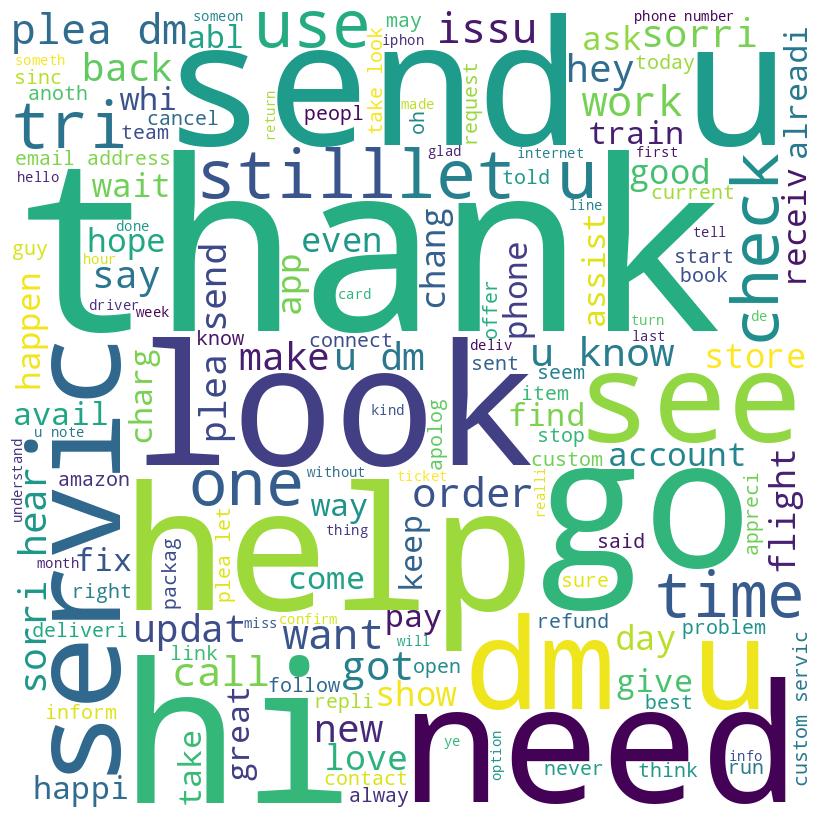

In [ ]:
# Visualization of Preprocessed Data
# Create a word cloud of the cleaned text data
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      max_words=150).generate(' '.join(df['clean_text']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# **Development of the Twitter Chatbot and Chatbot Recommender System**

In [ ]:
df['category'] = df['text'].apply(lambda x: 'question' if isinstance(x, str) and '?' in x else 'statement')

In [ ]:
# Vectorize the text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['category']

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a recommender system
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the performance of the recommender system
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# Twitter Chatbot

"""
consumer_key = '-'
consumer_secret = '-'
access_token = '-'
access_token_secret = '-'
bearer_token = '-'

# Develop a chatbot
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def get_recommendation(text):
    # Use the trained recommender system to provide personalized recommendations
    return "Replace your product."

# Create a subclass of tweepy.StreamingClient for Twitter API v2
class MyStream(tweepy.StreamingClient):
    def on_tweet(self, tweet):
        # Skip if it's a reply or from the same user
        if tweet.in_reply_to_status_id is not None or tweet.author_id == self.authenticated_user_id:
            return

        text = p.clean(tweet.text)
        sentiment = get_sentiment(text)

        if sentiment < -0.1:
            recommendation = get_recommendation(text)
            reply = "@" + tweet.author.screen_name + " " + recommendation
            api.update_status(reply, in_reply_to_status_id=tweet.id)
            print("Tweet replied to:", text)

# Instantiate MyStream with Bearer Token
my_stream = MyStream(bearer_token)

# Start the stream
my_stream.filter(tweet_fields=["author_id", "in_reply_to_status_id"])

"""

'\nconsumer_key = \'-\'\nconsumer_secret = \'-\'\naccess_token = \'-\'\naccess_token_secret = \'-\'\nbearer_token = \'-\'\n\n# Develop a chatbot\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_token_secret)\napi = tweepy.API(auth)\n\ndef get_sentiment(text):\n    return TextBlob(text).sentiment.polarity\n\ndef get_recommendation(text):\n    # Use the trained recommender system to provide personalized recommendations\n    return "Replace your product."\n\n# Create a subclass of tweepy.StreamingClient for Twitter API v2\nclass MyStream(tweepy.StreamingClient):\n    def on_tweet(self, tweet):\n        # Skip if it\'s a reply or from the same user\n        if tweet.in_reply_to_status_id is not None or tweet.author_id == self.authenticated_user_id:\n            return\n\n        text = p.clean(tweet.text)\n        sentiment = get_sentiment(text)\n\n        if sentiment < -0.1:\n            recommendation = get_recommendation(text)\n    

In [ ]:
nltk.download('punkt')

from nltk.tokenize import word_tokenize

recommendation_map = {
    # Product Inquiries
    'features': 'Our product comes with the following features...',
    'warranty': 'Our products have a one-year warranty covering...',
    'compatibility': 'This product is compatible with...',

    # Order and Shipping
    'track order': 'You can track your order here: [link]',
    'shipping time': 'The estimated shipping time is 3-5 business days.',
    'change address': 'To change your shipping address, please follow these steps...',

    # Technical Issues
    'not working': 'We’re sorry to hear that. Please follow these troubleshooting steps...',
    'error': 'This error might occur due to... Here’s how you can fix it:',

    # Returns and Refunds
    'return': 'You can return the product within 30 days of purchase. Here’s how:',
    'refund': 'To request a refund, please follow these instructions...',

    # Complaints and Feedback
    'complaint': 'We’re sorry to hear about your experience. We will forward your feedback...',
    'suggestion': 'Thank you for your suggestion! We appreciate feedback from our customers.',

    # Discounts and Promotions
    'discount': 'Check out our latest discounts here: [link]',
    'promo code': 'Use this promo code at checkout for a 10% discount: PROMO10',

    # General Information
    'opening hours': 'Our customer service is available from 9 am to 5 pm, Monday to Friday.',
    'contact': 'You can contact us at support@example.com or call us at 123-456-7890.',

    # Specific Issues or Requests
    'defective': 'Please return the defective product for a replacement or refund.',
    'size': 'To find the right size, please refer to our sizing guide here: [link]',
    'color': 'This product is available in the following colors: Red, Blue, Green...',
}

def get_recommendation(text):
    # Tokenize the text and convert to lower case
    words = word_tokenize(text.lower())

    # Check if any of the words in the text match our keywords
    for word in words:
        if word in recommendation_map:
            return recommendation_map[word]

    # Default response if no keywords are found
    return "Could you please provide more details about your issue?"

# Testing the function
print(get_recommendation("My product is defective."))
print(get_recommendation("How can I return my order?"))
print(get_recommendation("Are there any discount codes available?"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Please return the defective product for a replacement or refund.
You can return the product within 30 days of purchase. Here’s how:
Check out our latest discounts here: [link]


In [ ]:
# Sentiment Analysis
sample_queries = ['My product is defective.', 'I want to return my order.', 'Can you provide a discount code?']

for query in sample_queries:
    sentiment = TextBlob(query).sentiment
    print(f"Query: {query}\nSentiment: {sentiment}\n")

Query: My product is defective.
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Query: I want to return my order.
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Query: Can you provide a discount code?
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)



In [ ]:
# Test the chatbot using sample queries
sample_queries = ['My product is defective.', 'I want to return my order.', 'Can you provide a discount code?']
for query in sample_queries:
    recommendation = get_recommendation(query)
    print("Query:", query)
    print("Recommendation:", recommendation)

Query: My product is defective.
Recommendation: Please return the defective product for a replacement or refund.
Query: I want to return my order.
Recommendation: You can return the product within 30 days of purchase. Here’s how:
Query: Can you provide a discount code?
Recommendation: Check out our latest discounts here: [link]


# **Evaluation of the Chatbot Recommender System**

In [ ]:
# Measure response time
import time

start_time = time.time()
recommendation = get_recommendation("My product is defective.")
end_time = time.time()

response_time = end_time - start_time
print("Response time:", response_time)

Response time: 0.0001709461212158203


In [ ]:
# Improved test set with queries and their expected correct recommendations
test_set = [
    ("My product is defective.", "Please return the defective product for a replacement or refund."),
    ("How can I return my order?", "You can return the product within 30 days of purchase. Here’s how:"),
    ("Are there any discount codes available?", "Check out our latest discounts here: [link]")
]


# Measure accuracy
correct_predictions = 0

for query, correct_recommendation in test_set:
    recommendation = get_recommendation(query)
    if recommendation == correct_recommendation:
        correct_predictions += 1

accuracy = correct_predictions / len(test_set)
print("Accuracy:", accuracy)

Accuracy: 1.0


# **Working Chatbot**

In [ ]:
# A function to start the chatbot
def start_chatbot():
    print('Welcome to the Query Recommender Chatbot!')
    print('Please enter your question or type "exit" to end the conversation.')
    while True:
        # Get user input
        user_input = input('You: ')
        # Exit the chatbot if user input is "exit"
        if user_input == 'exit':
            print('Thank you for using the Chatbot!')
            break
        if user_input == 'Thank you':
            print('Your Welcome! I hope the issue is solved. Thank you for using the Chatbot!')
            break
        # Provide a recommendation based on user input
        else:
            response = get_recommendation(user_input)
            print('Chatbot:', response)

start_chatbot()

Welcome to the Query Recommender Chatbot!
Please enter your question or type "exit" to end the conversation.
You: I would like to return my order
Chatbot: You can return the product within 30 days of purchase. Here’s how:
You: Thank you
Your Welcome! I hope the issue is solved. Thank you for using the Chatbot!


#**Relevant Resources**


[NLTK - casual_tokenize for social media text tokenizing, vader sentiment analysis for social media text](http://www.nltk.org/howto/sentiment.html)


[SciKit Learn - BoW Count Vectorizer, Multinomial Naive Bayes Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)


[Topic Modeling via Phrase detection with gensim](https://www.thoughtvector.io/blog/topic-modeling-for-humans-with-phrase-detection/)


[facebook research - fastText text classifier](https://github.com/facebookresearch/fastText)

[Referred Project - Chatbot](https://github.com/aadimangla/Customer-Service-Bot/tree/master)